In [2]:
import os
import os.path
from PIL import Image

import torch
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math

import torchvision
from torchvision import transforms

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from models.vgg import VGG

In [3]:
VGG.__dict__

mappingproxy({'__module__': 'models.vgg',
              '__init__': <function models.vgg.VGG.__init__(self, vgg_name, landmark_num, base_dim=64, num_classes=7)>,
              'forward': <function models.vgg.VGG.forward(self, x)>,
              '_make_layers': <function models.vgg.VGG._make_layers(self, cfg)>,
              '__doc__': None})

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
torch.manual_seed(17)

# Dataset

In [7]:
def get_mean_std_dataset(dataset):
    meanRGB = [np.mean(image, axis=(1, 2)) for image,_ in dataset]
    stdRGB = [np.std(image, axis=(1, 2)) for image,_ in dataset]
    
    meanR = np.round( (np.mean([m[0] for m in meanRGB]) / 255), 3)
    meanG = np.round( (np.mean([m[1] for m in meanRGB]) / 255), 3)
    meanB = np.round( (np.mean([m[2] for m in meanRGB]) / 255), 3)
    
    stdR = np.round( (np.mean([s[0] for s in stdRGB]) / 255), 3)
    stdG = np.round( (np.mean([s[1] for s in stdRGB]) / 255), 3)
    stdB = np.round( (np.mean([s[2] for s in stdRGB]) / 255), 3)
    
    print("mean RGB:", meanR, meanG, meanB)
    print("std RGB:", stdR, stdG, stdB)
    
    return {"mean": [meanR, meanG, meanB], "std": [stdR, stdG, stdB]}

In [8]:
train_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/train")
test_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/test")

In [9]:
train_mean_std = get_mean_std_dataset(train_set)
print("mean and std of train set:", train_mean_std)
test_mean_std = get_mean_std_dataset(test_set)
print("mean and std of test set:", test_mean_std)

mean RGB: 0.418 0.435 0.448
std RGB: 0.24 0.237 0.234
mean and std of train set: {'mean': [0.418, 0.435, 0.448], 'std': [0.24, 0.237, 0.234]}
mean RGB: 0.417 0.433 0.446
std RGB: 0.237 0.234 0.231
mean and std of test set: {'mean': [0.417, 0.433, 0.446], 'std': [0.237, 0.234, 0.231]}


In [10]:
# dataset의 class 이름, class index 저장
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    classes_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, classes_to_idx

In [11]:
classes = find_classes("../data/refined_fer2013/train")[0]

In [12]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean_std['mean'], std=train_mean_std['std'])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean_std['mean'], std=test_mean_std['std'])
])

In [13]:
train_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/train",
                                            transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/test",
                                           transform=test_transform)

In [14]:
# batch size
batch_size = 16

train_loader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_set,
                        batch_size=batch_size,
                        shuffle=True)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(len(labels))

16


In [16]:
def imshow(img):
    img = img/2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print((np.transpose(np_img, (1, 2 ,0))).shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
angry angry happy neutral   sad happy  fear surprise  fear angry  fear angry surprise   sad angry   sad 


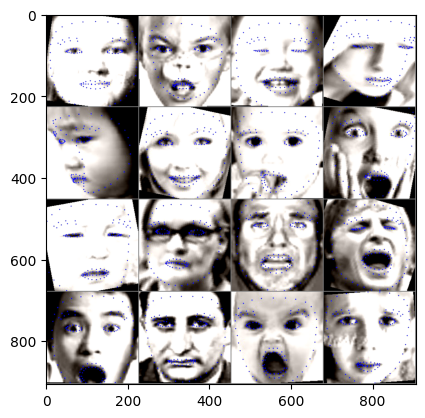

In [17]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s " % classes[labels[j]] for j in range(16)))

# Model
https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C-CNN-%EB%AA%A8%EB%8D%B8%EC%9D%84-%EA%B5%AC%ED%98%84%ED%95%B4%EB%B3%B4%EC%9E%90-VGGNet%ED%8E%B8

In [ ]:
def conv_2_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

In [ ]:
def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    return model

In [ ]:
class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=7):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3, base_dim),            # 64
            conv_2_block(base_dim, 2*base_dim),   # 128
            conv_3_block(2*base_dim, 4*base_dim), # 256
            conv_3_block(4*base_dim, 8*base_dim), # 512
            conv_3_block(8*base_dim, 8*base_dim), # 512
        )
        self.fc_layer = nn.Sequential(
            # imagenet은 224x224
            nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )
        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [17]:
# 직접 생성한 VGG Net
# model = VGG(base_dim=64).to(device)

# pytorch에서 제공하는 VGG16
# model = torchvision.models.vgg16(pretrained=True)

# 논문에서 가져 VGG Net
model = VGG(vgg_name='VGG16', landmark_num=124).to(device)

In [23]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [21]:
# 손실 함수 및 최적화 함수
num_epoch = 40
learning_rate = 0.1
criterion = nn.CrossEntropyLoss().to(device)
optimizer = "adam"

In [22]:
if optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-4)
elif optimizer == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=0.9,
                                weight_decay = 1e-4)
else:
    raise ValueError("Optimizer not supported.")

# Trainig the Model

https://076923.github.io/posts/Python-pytorch-10/

In [24]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
loss_list = []

for epoch in tqdm(range(num_epoch), desc="epoch"):
    cost = 0.0
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        attention_weights, weighted_prob, land_2d = model.forward(x)
        loss = criterion(weighted_prob, y_)
        
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        
        
    batch_loss = cost / len(train_loader)
    loss_list.append(batch_loss)
    print(f'[{epoch+1}] loss: {batch_loss:.3f}')

epoch:   2%|▊                                 | 1/40 [04:49<3:08:00, 289.23s/it]

[1] loss: 1.987


epoch:   5%|█▋                                | 2/40 [09:41<3:04:17, 291.00s/it]

[2] loss: 1.946


epoch:   8%|██▌                               | 3/40 [14:33<2:59:41, 291.39s/it]

[3] loss: 1.947


epoch:  10%|███▍                              | 4/40 [19:22<2:54:23, 290.65s/it]

[4] loss: 1.947


epoch:  12%|████▎                             | 5/40 [24:11<2:49:07, 289.93s/it]

[5] loss: 1.946


epoch:  15%|█████                             | 6/40 [29:01<2:44:16, 289.90s/it]

[6] loss: 1.907


epoch:  18%|█████▉                            | 7/40 [33:50<2:39:22, 289.77s/it]

[7] loss: 1.868


epoch:  20%|██████▊                           | 8/40 [38:39<2:34:16, 289.26s/it]

[8] loss: 1.916


epoch:  22%|███████▋                          | 9/40 [43:28<2:29:32, 289.43s/it]

[9] loss: 1.761


epoch:  25%|████████▎                        | 10/40 [48:18<2:24:41, 289.38s/it]

[10] loss: 1.464


epoch:  28%|█████████                        | 11/40 [53:06<2:19:45, 289.17s/it]

[11] loss: 1.327


epoch:  30%|█████████▉                       | 12/40 [57:54<2:14:42, 288.66s/it]

[12] loss: 1.265


epoch:  32%|██████████                     | 13/40 [1:02:40<2:09:36, 288.03s/it]

[13] loss: 1.223


epoch:  35%|██████████▊                    | 14/40 [1:07:26<2:04:33, 287.46s/it]

[14] loss: 1.187


epoch:  38%|███████████▋                   | 15/40 [1:12:13<1:59:39, 287.20s/it]

[15] loss: 1.154


epoch:  40%|████████████▍                  | 16/40 [1:16:59<1:54:41, 286.71s/it]

[16] loss: 1.123


epoch:  42%|█████████████▏                 | 17/40 [1:21:44<1:49:46, 286.38s/it]

[17] loss: 1.094


epoch:  45%|█████████████▉                 | 18/40 [1:26:30<1:44:56, 286.21s/it]

[18] loss: 1.069


epoch:  48%|██████████████▋                | 19/40 [1:31:15<1:40:05, 285.97s/it]

[19] loss: 1.044


epoch:  50%|███████████████▌               | 20/40 [1:36:01<1:35:17, 285.87s/it]

[20] loss: 1.021


epoch:  52%|████████████████▎              | 21/40 [1:40:46<1:30:28, 285.68s/it]

[21] loss: 1.005


epoch:  55%|█████████████████              | 22/40 [1:45:32<1:25:40, 285.60s/it]

[22] loss: 0.989


epoch:  57%|█████████████████▊             | 23/40 [1:50:18<1:20:56, 285.67s/it]

[23] loss: 0.963


epoch:  60%|██████████████████▌            | 24/40 [1:55:03<1:16:10, 285.63s/it]

[24] loss: 0.944


epoch:  62%|███████████████████▍           | 25/40 [1:59:49<1:11:24, 285.64s/it]

[25] loss: 0.921


epoch:  65%|████████████████████▏          | 26/40 [2:04:34<1:06:38, 285.62s/it]

[26] loss: 0.908


epoch:  68%|████████████████████▉          | 27/40 [2:09:19<1:01:50, 285.46s/it]

[27] loss: 0.889


epoch:  70%|███████████████████████          | 28/40 [2:14:05<57:04, 285.35s/it]

[28] loss: 0.866


epoch:  72%|███████████████████████▉         | 29/40 [2:18:50<52:18, 285.30s/it]

[29] loss: 0.853


epoch:  75%|████████████████████████▊        | 30/40 [2:23:35<47:33, 285.36s/it]

[30] loss: 0.837


epoch:  78%|█████████████████████████▌       | 31/40 [2:28:20<42:47, 285.27s/it]

[31] loss: 0.819


epoch:  80%|██████████████████████████▍      | 32/40 [2:33:06<38:02, 285.37s/it]

[32] loss: 0.802


epoch:  82%|███████████████████████████▏     | 33/40 [2:37:51<33:17, 285.36s/it]

[33] loss: 0.788


epoch:  85%|████████████████████████████     | 34/40 [2:42:36<28:31, 285.25s/it]

[34] loss: 0.767


epoch:  88%|████████████████████████████▉    | 35/40 [2:47:22<23:46, 285.28s/it]

[35] loss: 0.753


epoch:  90%|█████████████████████████████▋   | 36/40 [2:52:07<19:01, 285.32s/it]

[36] loss: 0.742


epoch:  92%|██████████████████████████████▌  | 37/40 [2:56:52<14:15, 285.26s/it]

[37] loss: 0.726


epoch:  95%|███████████████████████████████▎ | 38/40 [3:01:37<09:30, 285.24s/it]

[38] loss: 0.708


epoch:  98%|████████████████████████████████▏| 39/40 [3:06:23<04:45, 285.25s/it]

[39] loss: 0.703


epoch: 100%|█████████████████████████████████| 40/40 [3:11:08<00:00, 286.71s/it]

[40] loss: 0.693


loss 시각화

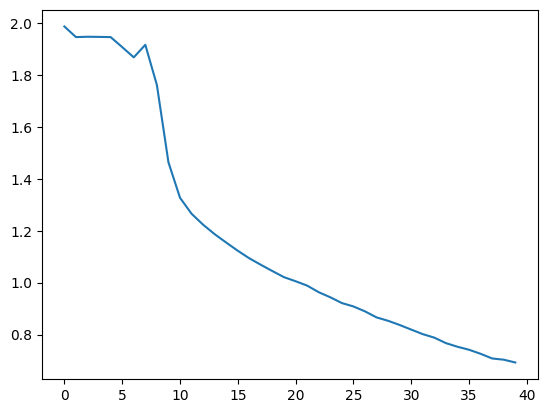

In [26]:
plt.plot(loss_list)
plt.show()

# Save Model

In [27]:
torch.save(model.state_dict(), './pretrained/refined_fer_vggnet.pt')

In [52]:
# 맞은 개수, 전체 개수
correct = 0
total = 0

saved_model.eval()

# no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러온다
    for image, label in train_loader:
        x = image.to(device)
        y = label.to(device)
        
        # 모델에 데이터를 넣고 결과값 저장
        _, output, _ = saved_model.forward(x)
        _, output_index = torch.max(output, 1)
        
        # 전체 개수 += label의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # accuracy
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 82.3611831665039%


# Test

In [31]:
# 맞은 개수, 전체 개수
correct = 0
total = 0

model.eval()

# no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러온다
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        # 모델에 데이터를 넣고 결과값 저장
        _, output, _ = model.forward(x)
        _, output_index = torch.max(output, 1)
        
        # 전체 개수 += label의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # accuracy
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 63.338157653808594%


# Load Model

In [18]:
saved_model = VGG(vgg_name='VGG16', landmark_num=124).to(device)

In [19]:
saved_model.load_state_dict(torch.load('./pretrained/refined_fer_vggnet.pt'))

<All keys matched successfully>

In [20]:
# 맞은 개수, 전체 개수
correct = 0
total = 0

saved_model.eval()

# no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러온다
    for image, label in test_loader:
        x = image.to(device)
        y = label.to(device)
        
        # 모델에 데이터를 넣고 결과값 저장
        _, output, _ = saved_model.forward(x)
        _, output_index = torch.max(output, 1)
        
        # 전체 개수 += label의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # accuracy
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

Accuracy of Test Data: 63.338157653808594%


In [25]:
number_of_labels = len(classes)

In [44]:
# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    
    with torch.no_grad():
        for image, labels in test_loader:
            x = image.to(device)
            y = labels.to(device)
            
            if(len(y) != 16):
                print("check")
            _, outputs, _ = saved_model.forward(x)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == y).squeeze()
            for i in range(batch_size):
                label = y[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [45]:
testClassess()

check


IndexError: index 11 is out of bounds for dimension 0 with size 11

In [47]:
class_correct = list(0. for i in range(number_of_labels))
class_total = list(0. for i in range(number_of_labels))

with torch.no_grad():
    for image, labels in test_loader:
        x = image.to(device)
        y = labels.to(device)

        if(len(y) != 16):
            print("check")
        _, outputs, _ = saved_model.forward(x)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for i in range(batch_size):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(number_of_labels):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

check


IndexError: index 11 is out of bounds for dimension 0 with size 11

In [48]:
y

tensor([2, 2, 3, 6, 0, 3, 6, 2, 6, 0, 3], device='cuda:0')

In [49]:
len(y)

11

## Confusion Matrix

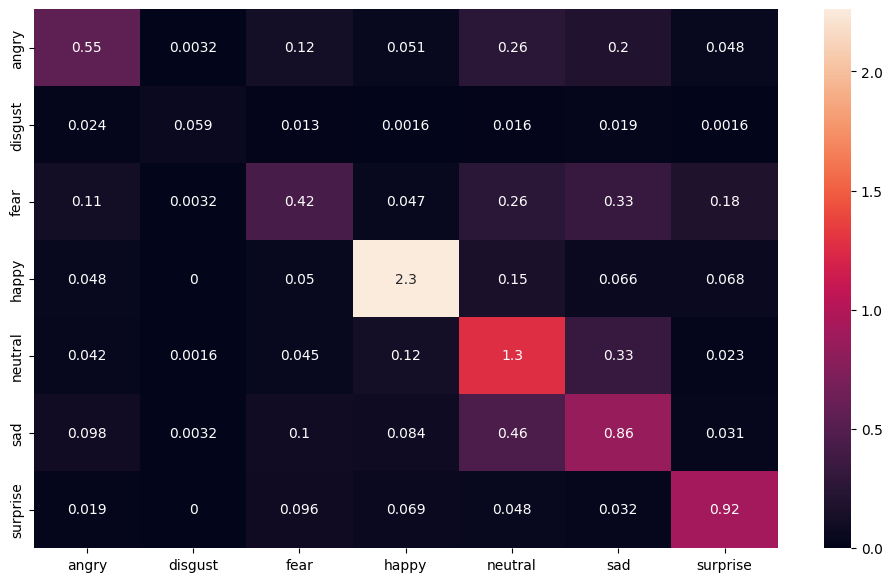

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iter over test data
for image, labels in test_loader:
    x = image.to(device)
    y = labels.to(device)
    
    _, output, _ = saved_model.forward(x)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # save prediction
    
    y = y.data.cpu().numpy()
    y_true.extend(labels) # save truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')